In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
import time

In [2]:
%matplotlib inline
plt.rcParams['font.family'] = 'NanumGothic'

In [3]:
sns.set(style='ticks')
plt.rcParams['figure.figsize'] = [15, 15]

# 데이터 로드

## 이탈 당시 SILVER 이상 회원 목록 가져오기

In [122]:
out = pd.read_csv('table/new_inflow_total.csv')
workchurn = pd.read_csv('table/churn_worker_info.csv')
checkchurn = pd.read_csv('table/churn_checker_info.csv')

In [132]:
highmemlist = out[out['cumul_point']>=50000]['user'].unique()

In [29]:
wcdf = workchurndf[workchurndf['gidx']>2]
ccdf = checkchurndf[checkchurndf['gidx']>2]

# SILVER 이상 이탈자 관련 정보 로드 및 가공

In [48]:
dfmember = pd.read_csv('table/member.csv')

C:\Users\wcid\anaconda3\envs\ai-env\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,24,26,27,35,42,46,51,52,53,67,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
dfmember = dfmember[['member_id', 'member_type_cd', 'gender_cd', 'age', 'reg_date', 'residence1', 'residence2', 'residence3']]

In [52]:
dfmember

member_id member_type_cd gender_cd  age             reg_date  \
0               0          ADMIN       NaN  NaN  2016-12-16 16:09:41   
1            1001          ADMIN         F  NaN  2017-04-26 16:20:52   
2            1009        CHECKER       NaN  NaN  2018-02-06 10:43:17   
3            2001         SYSTEM         M  NaN  2019-08-26 16:25:13   
4            3001        CHECKER       NaN  NaN  2018-03-30 15:58:31   
...           ...            ...       ...  ...                  ...   
150400     161274         WORKER         F  NaN  2020-06-05 13:31:43   
150401     161275         WORKER         M  NaN  2020-06-05 14:12:48   
150402     161276         WORKER         M  NaN  2020-06-05 14:27:53   
150403     161277         WORKER         M  NaN  2020-06-05 15:10:54   
150404     161278         WORKER         F  NaN  2020-06-05 15:26:36   

       residence1 residence2 residence3  
0             NaN        NaN        NaN  
1             NaN        NaN        NaN  
2             NaN        NaN        NaN  
3           서울특별시        강남구        역삼동  
4             NaN        NaN        NaN  
...           ...        ...        ...  
150400      인천광역시        부평구       삼산1동  
150401      부산광역시        연제구       연산5동  
150402      광주광역시         북구        용봉동  
150403      서울특별시       동대문구       전농2동  
150404      서울특별시        송파구        오금동  

[150405 rows x 8 columns]

In [123]:
ccdf

member_id  churn_date  gidx        grade
1        18983  2019-03-26     6    GOLD_PLUS
3        20013  2019-04-08     6    GOLD_PLUS
4        20012  2019-04-08     6    GOLD_PLUS
5        21097  2019-04-09     5         GOLD
6        21012  2019-04-09     5         GOLD
..         ...         ...   ...          ...
506     106797  2020-02-24     3       SILVER
514     107995  2020-02-28     3       SILVER
516      26914  2020-03-02     6    GOLD_PLUS
517     100370  2020-03-02     3       SILVER
518      40181  2020-03-02     4  SILVER_PLUS

[394 rows x 4 columns]

In [68]:
def posteriorMean(m, smean, n, N, w):
    if n==0 and N==0:
        return 0
    return (N*m + 2*n*w*smean) / (2*n*w + N)

def strToTimestamp(x):
    return time.mktime(datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').timetuple())

def calculateBT(x):
    if x['prog_state_cd'] in ['WORK_END', 'CHECK_REWORK']:
        diff = strToTimestamp(x['work_edate']) - strToTimestamp(x['work_sdate'])
        return math.log(diff) if diff > 0 else 0
    else:
        return 0
    
def calculateWT(x):
    if x['prog_state_cd'] == 'CHECK_REWORK':
        diff = strToTimestamp(x['work_sdate']) - strToTimestamp(x['check_edate'])
        return math.log(diff) if diff > 0 else 0
    else:
        return 0
    
def calculateCw(x, w1, w2, w3):
    if x['c']==0 or x['a']==0 or x['e']==0:
        return 0
    else:
        return (w1+w2+w3) /  (w1/x['c'] + w2/x['a'] + w3/x['e'])
    
dfprj = pd.read_csv('./inspect/table/CW_PROJECT.csv')
dfprj['reg_ts'] = dfprj['reg_date'].apply(lambda x:strToTimestamp(x))
dfprj['end_ts'] = dfprj['end_date'].apply(lambda x:strToTimestamp(x))
dfprj = dfprj[dfprj['project_progress_cd']=='ENDED']
dfprj = dfprj[dfprj['reg_ts']>=strToTimestamp('2019-04-01 00:00:00')]
dfprj = dfprj[dfprj['end_ts']<strToTimestamp('2020-04-01 00:00:00')]
prjlist = dfprj['project_id']
dfhist = pd.concat([pd.read_csv('./inspect/table/CW_DATA_HIST_5.csv'), pd.read_csv('./inspect/table/CW_DATA_HIST_4.csv')])
dfhist = pd.concat([dfhist, pd.read_csv('./inspect/table/CW_DATA_HIST_3.csv')])
dfhist = pd.concat([dfhist, pd.read_csv('./inspect/table/CW_DATA_HIST_2.csv')])
dfhist = pd.concat([dfhist, pd.read_csv('./inspect/table/CW_DATA_HIST_1.csv')])
dfdata = pd.concat([pd.read_csv('./inspect/table/TB_PRJ_DATA_5.csv'), pd.read_csv('./inspect/table/TB_PRJ_DATA_4.csv')])
dfdata = pd.concat([dfdata, pd.read_csv('./inspect/table/TB_PRJ_DATA_3.csv')])
dfdata = pd.concat([dfdata, pd.read_csv('./inspect/table/TB_PRJ_DATA_2.csv')])
dfdata = pd.concat([dfdata, pd.read_csv('./inspect/table/TB_PRJ_DATA_1.csv')])
dfm = pd.merge(dfhist, dfdata[['data_idx', 'prj_idx', 'project_id', 'work_user']], how='left', left_on='data_id', right_on='data_idx')

dfm = dfm[dfm['worker_id']==dfm['work_user']]
dfm = dfm[dfm['prog_state_cd'].isin(['WORK_END','CHECK_END', 'CHECK_REJECT', 'CHECK_REWORK'])]
dfm = dfm.drop(dfm[dfm['prog_state_cd']=='CHECK_REWORK'][dfm['check_edate']!=dfm['check_edate']].index, 0)

dfm['prj_idx'] = dfm['prj_idx'].apply(lambda x:round(x))
dfm['project_id'] = dfm['project_id'].apply(lambda x:round(x))
dfm['passed'] = dfm['prog_state_cd'].apply(lambda x : (1 if x=='CHECK_END' else 0))
dfm['rejected'] = dfm['prog_state_cd'].apply(lambda x : (1 if x=='CHECK_REJECT' else 0))
dfm['bt'] = dfm.apply(calculateBT, axis=1)
dfm['wt'] = dfm.apply(calculateWT, axis=1)

data = pd.DataFrame()

for prj in prjlist:
    df = dfm[dfm['project_id']==prj]
    
    if len(df)==0:
        continue

    sample = df.copy()
    sample = sample.sample(frac=1)
    sample = sample.sort_values(["worker_id"])
    
    r = len(sample[sample['prog_state_cd']=='CHECK_REJECT']) # 프로젝트 반려 건수
    d = len(sample[sample['prog_state_cd']=='CHECK_END'])    # 프로젝트 통과 건수
    h = r+d                                                  # 프로젝트 총 작업 건수 
    
    if d<20 or r<10:
        continue
        
    workgrpsum = sample[sample['prog_state_cd'].isin(['WORK_END', 'CHECK_REWORK'])].groupby('worker_id').sum()
    checkgrp = sample[sample['prog_state_cd'].isin(['CHECK_END', 'CHECK_REJECT'])]
    workgrpsum = workgrpsum[workgrpsum.index.isin(checkgrp.groupby('worker_id').first().index)]
    checkgrp = checkgrp[checkgrp['worker_id'].isin(workgrpsum.index)].groupby('worker_id')
    
    target = checkgrp.first()
    
    p = d/h                  # 프로젝트 작업 통과율
    w = len(target)          # 프로젝트 작업자 수
    BT = workgrpsum['bt']    # 프로젝트 실행 Log 시간 총합
    WT = workgrpsum['wt']    # 프로젝트 대기 Log 시간 총합

    target['project_id']=prj
    target['d'] = checkgrp.sum()['passed']
    target['r'] = checkgrp.sum()['rejected']
    target['h'] = checkgrp.count()['data_id']
    target['p'] = target.apply(lambda x : (d+2*w*(x['h']-x['r']))/(h+2*w*x['h']) , axis=1)   # 작업자 작업 통과율 추정치

    btmean = sample[sample['prog_state_cd'].isin(['WORK_END', 'CHECK_REWORK'])]['bt'].mean()
    wtmean = sample[sample['prog_state_cd'].isin(['CHECK_REWORK'])]['wt'].mean()
    wtmean = 0 if math.isnan(wtmean) or math.isinf(wtmean) else wtmean

    ext = workgrpsum
    target['bt'] = ext['bt']/target['h']
    target['wt'] = ext['wt']/target['r']
    target['wt'] = target['wt'].apply(lambda x : 0 if math.isnan(x) or math.isinf(x) else x)
    target['bte'] = target.apply(lambda x : posteriorMean(btmean, x['bt'], x['h'], h, w), axis=1)  # 작업자 실행 Log 시간 추정치
    target['wte'] = target.apply(lambda x : posteriorMean(wtmean, x['wt'], x['r'], r, w), axis=1)  # 작업자 대기 Log 시간 추정치

    bmin = target['bte'].min()
    bmax = target['bte'].max()
    bmean = target['bte'].mean()
    wmin = target['wte'].min()
    wmax = target['wte'].max()
    wmean = target['wte'].mean()
    rtu = (bmax**2+wmax**2-(bmean**2 + wmean**2)) / (bmax**2-bmin**2+wmax**2-wmin**2) if bmax+wmax!=bmin+wmin else 0.5
    target['rte'] = target.apply(lambda x : (bmax**2+wmax**2-(bmean*x['bte'] + wmean*x['wte'])) / (bmax**2-bmin**2+wmax**2-wmin**2)
                               if bmax+wmax!=bmin+wmin else 0.5, axis=1)   # 작업자 응답 수준 추정치

    target['c'] = target['d'].apply(lambda x : 0 if x==0 else 2 ** (math.log(x/d)/math.log(w)) if w>1 else 0.5) # 작업 기여도 c
    target['a'] = target.apply(lambda x : 2 ** (-math.log(x['p']) / math.log(p)) if p<1 else 0.5, axis=1)       # 작업 정확도 a
    target['e'] = target.apply(lambda x : 2 ** (-math.log(x['rte']) / math.log(rtu)), axis=1)                    # 작업 처리 효율 e
    target['Cw'] = target.apply(lambda x : calculateCw(x, 1, 1, 1), axis=1)
    
    tmp = target[['project_id','d','r','h','bt','wt','p','bte','wte', 'rte', 'c','a','e','Cw']].reset_index()
    data = pd.concat([data, tmp])
    
data

C:\Users\wcid\anaconda3\envs\ai-env\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


worker_id  project_id    d    r    h        bt         wt         p  \
0        14397        1580    9    8   17  4.584290  15.221035  0.508268   
1        15163        1580  176  152  328  4.645210   6.605912  0.528157   
2        15403        1580  150  136  286  5.537664   6.768723  0.518776   
3        16337        1580   24   11   35  4.899031  16.247481  0.545792   
4        17300        1580   42   29   71  5.055867   6.397156  0.537203   
..         ...         ...  ...  ...  ...       ...        ...       ...   
175     138308        2937   96   85  181  2.846880   8.643430  0.544196   
176     138329        2937   55   27   82  3.633057   9.035363  0.682997   
177     138768        2937    9    5   14  3.687281  10.771614  0.700920   
178     138780        2937    7    6   13  3.788446   9.721271  0.646247   
179     139070        2937    1    0    1  3.218876   0.000000  0.795465   

          bte        wte       rte         c         a         e        Cw  
0    5.008802   9.209963  0.884833  0.319705  0.502987  0.498885  0.421320  
1    4.759228   7.114340  0.938519  0.532264  0.522979  0.697251  0.574152  
2    5.398233   7.268954  0.926217  0.517875  0.513548  0.646876  0.553088  
3    5.030445   9.624002  0.874597  0.378250  0.540715  0.466964  0.452171  
4    5.063813   7.750232  0.919153  0.416337  0.532076  0.619333  0.508822  
..        ...        ...       ...       ...       ...       ...       ...  
175  2.884212   8.641196  0.534794  0.631416  0.188834  0.513262  0.339838  
176  3.619028   8.996661  0.473867  0.586173  0.351866  0.451191  0.443503  
177  3.611159  10.053952  0.377498  0.460358  0.377743  0.354108  0.392489  
178  3.663304   9.389582  0.436228  0.445172  0.302393  0.413102  0.376223  
179  3.487193   8.562275  0.518685  0.343341  0.534249  0.496803  0.441357  

[56904 rows x 15 columns]

# 분석

In [121]:
wdf

work_user  work_point  work_grade           work_edate   work_date
0          38697.0        20.0           0  2020-06-01 00:00:12  2020-06-01
1          37324.0       100.0           6  2020-06-01 00:00:04  2020-06-01
2          38697.0        20.0           0  2020-05-31 23:59:10  2020-05-31
3         160697.0        20.0           0  2020-05-31 23:58:57  2020-05-31
4          38697.0        20.0           0  2020-05-31 23:58:36  2020-05-31
...            ...         ...         ...                  ...         ...
7073358    12886.0      1680.0           6  2019-04-01 00:09:43  2019-04-01
7073359    15699.0       630.0           6  2019-04-01 00:12:29  2019-04-01
7073360    20064.0       630.0           6  2019-04-01 00:19:44  2019-04-01
7073361    20828.0      2730.0           4  2019-04-01 00:13:27  2019-04-01
7073362    20876.0       630.0           4  2019-04-01 00:05:40  2019-04-01

[7059185 rows x 5 columns]

In [97]:
target = data[(data['worker_id'].isin(wcdf['member_id'])) | (data['worker_id'].isin(ccdf['member_id']))]

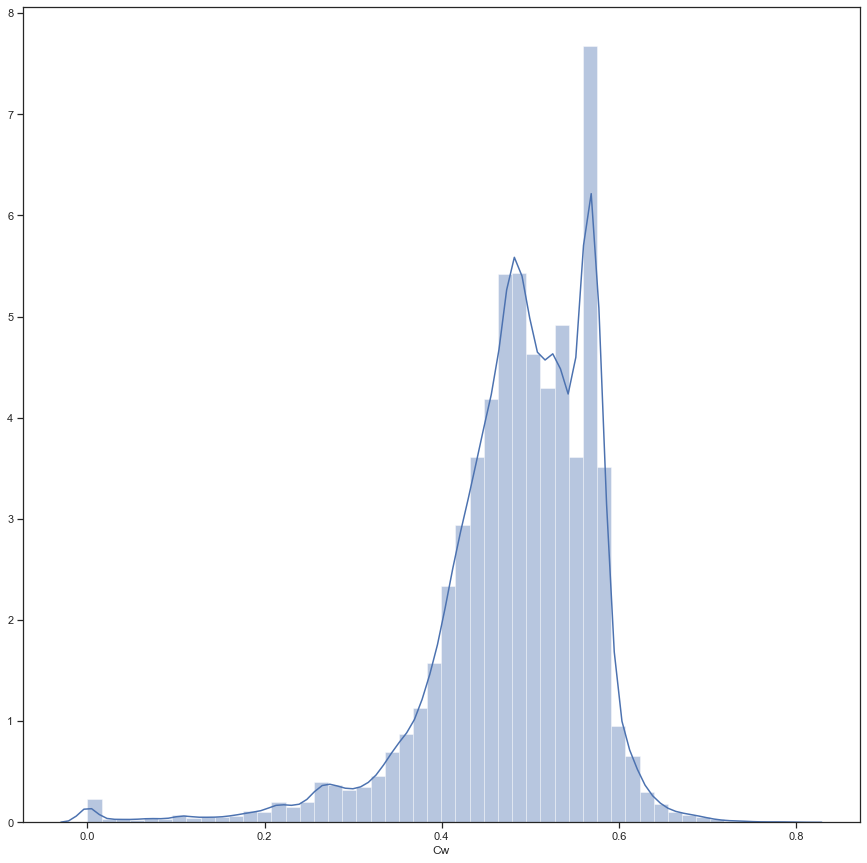

In [102]:
sns.distplot(data['Cw'])

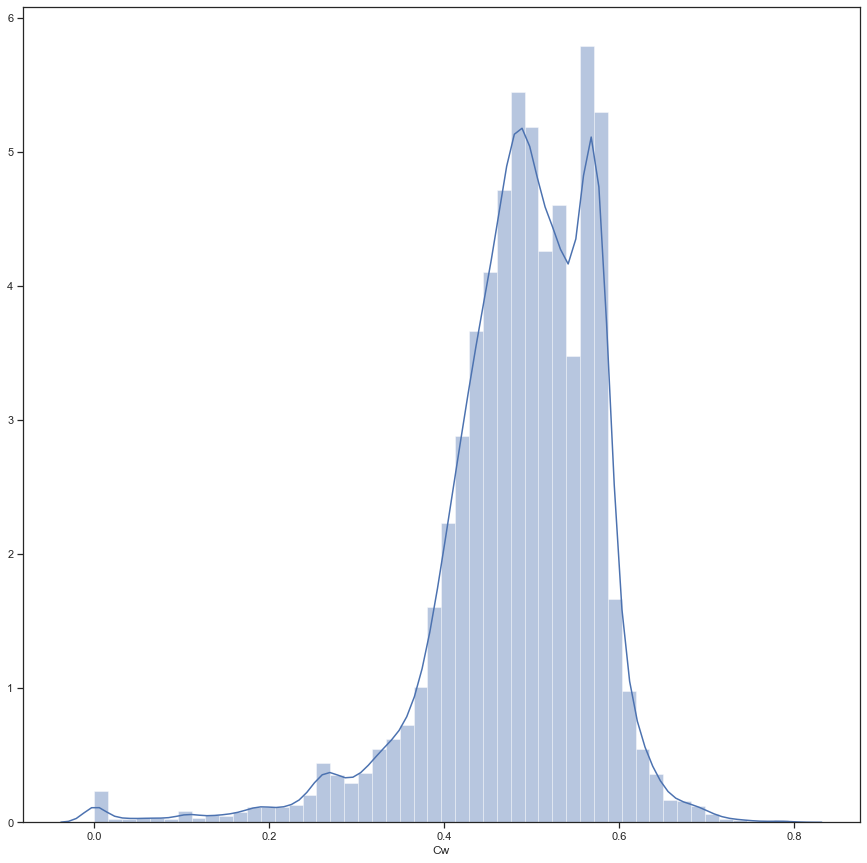

In [101]:
sns.distplot(target['Cw'])

In [115]:
tmp = target.groupby('worker_id').count().reset_index()
sns.distplot(tmp['project_id'])

## 이탈자 성별 분포 관련
- 작업자의 경우, 전체 회원의 성별 분포는 남성이 더 많으나 이탈자의 경우 여성이 더 많음
- 검수자의 경우, 전체와 이탈자 모두 여성의 비율이 높으나 이탈자의 경우에서 차이가 더 큼

- **<U>대체로 남성 회원보다 여성 회원의 이탈률이 높음</U>**

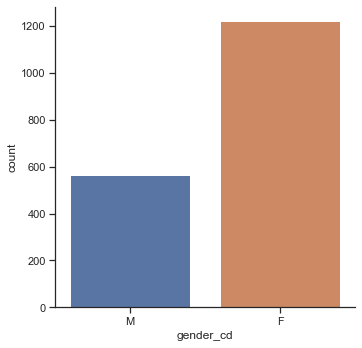

In [65]:
sns.catplot(x='gender_cd', kind='count', data=dfmember[dfmember['member_id'].isin(wcdf['member_id'])])

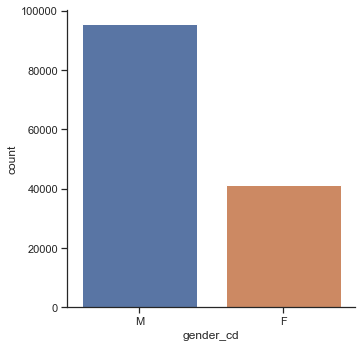

In [64]:
sns.catplot(x='gender_cd', kind='count', data=dfmember[dfmember['member_type_cd']=='WORKER'])

In [66]:
sns.catplot(x='gender_cd', kind='count', data=dfmember[dfmember['member_id'].isin(ccdf['member_id'])])

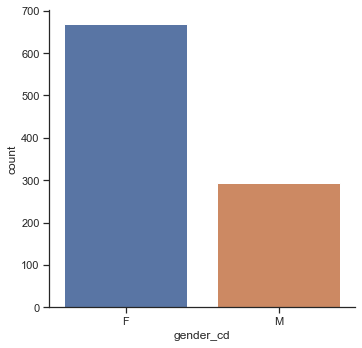

In [59]:
sns.catplot(x='gender_cd', kind='count', data=dfmember[dfmember['member_type_cd']=='CHECKER'])

## 이탈자 나이 분포 관련
- 작업자의 경우, 전체 회원의 나이 분포와 차이가 없음
- **<U>검수자의 경우, 전체 검수자 나이 분포에 비해 20대 이탈자가 적고 30대 초반 이탈자가 가장 많음</U>**
    - 이탈 검수자 수 자체가 적어 편향 가능성 있음

In [47]:
sns.catplot(x='age', kind='count', data=dfmember[dfmember['member_id'].isin(ccdf['member_id'])], height=15)

In [50]:
sns.catplot(x='age', kind='count', data=dfmember[dfmember['member_type_cd']=='CHECKER'], height=15)

## 이탈 일자 관련
- 일정 수준 이상의 작업자와 검수자 모두 **<U>2019-11 ~ 2020-01 사이에 이탈자가 증가</U>**함
- 당시의 오픈 프로젝트 현황이나 이슈를 분석하는 것이 필요해 보임

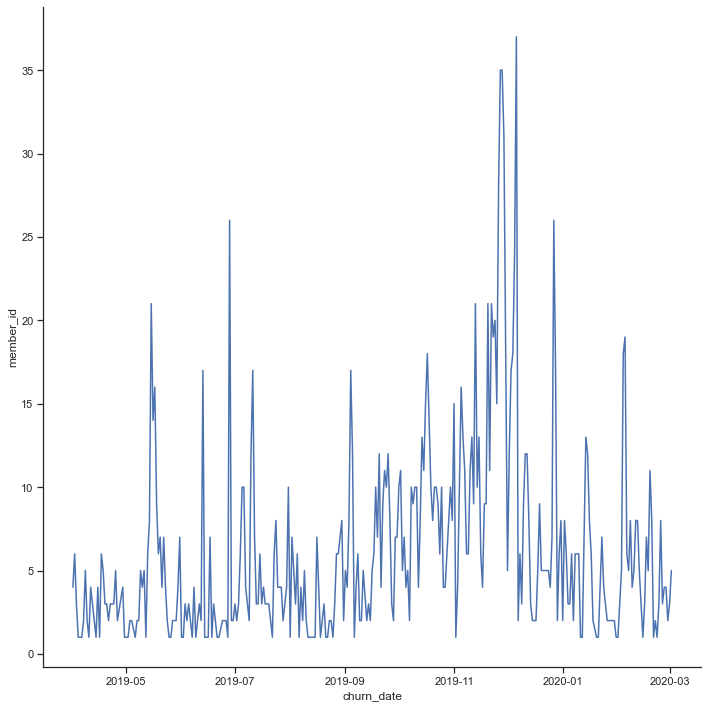

In [30]:
sns.relplot(x='churn_date', y='member_id', kind='line', data=wcdf.groupby('churn_date').count().reset_index(), height=10)

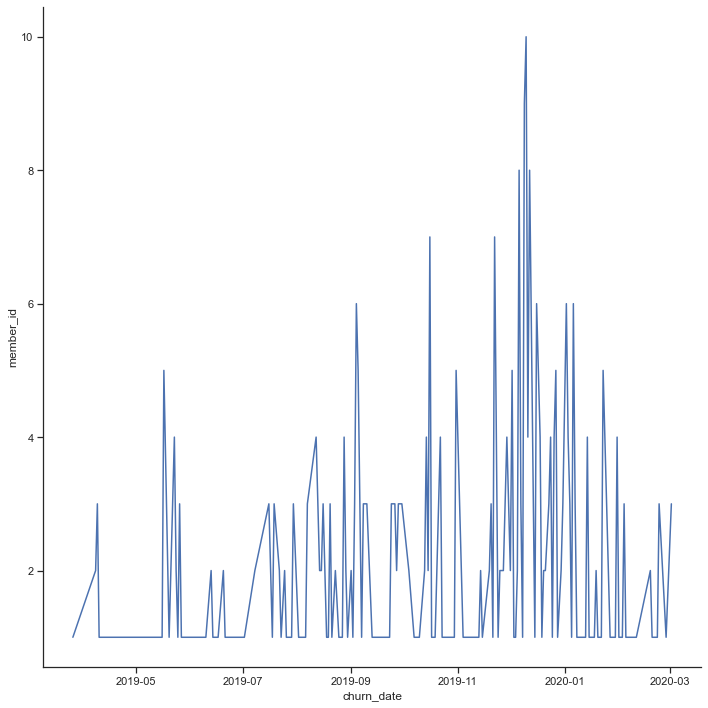

In [31]:
sns.relplot(x='churn_date', y='member_id', kind='line', data=ccdf.groupby('churn_date').count().reset_index(), height=10)